# Foundations of Data Mining: Assignment 3
Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [10]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
InteractiveShell.ast_node_interactivity = "all" 

import itertools
import math
from sklearn.decomposition import PCA

##  Random Projections with 1-NN (6 points, 3+3)

Implement random projections for dimensionality reduction as follows.
Randomly generate a $k \times d$ matrix $\bf R$ by choosing its coefficients
$$
r_{i,j}=
\begin{cases}
+\frac{1}{{\sqrt{d}}} \quad \text{with probability}\quad &\frac{1}{2}\\
-\frac{1}{\sqrt{d}} \quad \text{with probability} \quad & \frac{1}{2}
\end{cases}
$$ 
Let $f:\mathbb{R}^d \rightarrow \mathbb{R}^k$ denote the linear mapping function that 
multiplies a $d$-dimensional vector with this matrix $f(p)={\bf R}p$.
For the following exercises use the same data set as was used for Assignment 1 (MNIST). 
Use the following values of $k=45,90,400$ in your experiments.  
You should _not_ use sklearn.random_projection for this assignment.


###  Study the effect on pairwise distances
Evaluate how well the Euclidean distance is preserved by plotting a histogram of the 
values $\phi(p,q) = \frac{\|f(p)-f(q)\|}{\|p-q\|}$ for all pairs of the first 500 images of the MNIST data set. These values should be concentrated around a certain value for fixed $k$. What is this value expressed in terms of $k$ and $d$? Explain your answer.


In [2]:
mnist_data = oml.datasets.get_dataset(554)
X, y = mnist_data.get_data(target=mnist_data.default_target_attribute);

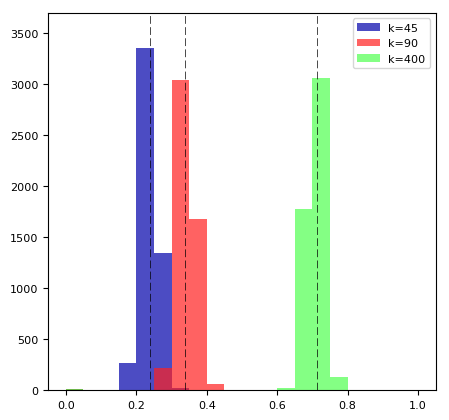

In [16]:
def get_random_proj(dimfrom, dimto):
    rand = np.random.randint(0, 2, size=(dimto, dimfrom))
    proj = (2 * rand - 1) / math.sqrt(dimfrom)
    return proj


plt.figure(figsize=(5, 5))
for i, k in enumerate([45, 90, 400]):
    reduced = X[:500].dot(get_random_proj(X.shape[1], k).T)
    assert reduced.shape == (500, k)
    
    distances = []
    for img in range(10):
        dists_proj = np.sqrt(((reduced - reduced[img])**2).sum(axis=1))
        dists_orig = np.sqrt(((X[:500] - X[img])**2).sum(axis=1))
        dists = np.divide(dists_proj, dists_orig, out=np.zeros(500),
                          where=dists_orig != 0)
        distances.extend(dists)
    
    plt.hist(distances, bins=np.arange(0, 1.01, 0.05),
             label='k=%d' % k, alpha=0.7);
    
    exval_phi = math.sqrt(float(k) / X.shape[1])
    plt.plot([exval_phi, exval_phi], [0, 4000], 'k--');

plt.ylim((0, 3700));
plt.legend();
plt.show();

We now prove that the expected value of $\phi(p, q)$ is $(k/d)^{1/2}$, for fixed $p$ and $q$. By linearity of $f$,

$$
\mathbb{E}\left[\Vert f(p)-f(q)\Vert^2 \right] = \mathbb{E}\left[\Vert f(p-q)\Vert^2\right]
$$

Let $\alpha=p-q$ and $\bf r_i$ be the i-th row of $\bf R$, then, by definition of squared norm and linearity of the expectation, we have:

$$
\mathbb{E}{\left[\Vert f(\alpha)\Vert^2\right]}
=\sum_{i=1}^{k}{\mathbb{E}\left[(\bf r_i\alpha)^2\right]}
$$

Following the same proof presented in class, $\mathbb{E}\left[(\bf r_i \alpha)^2\right] = d^{-1}\Vert\alpha\Vert^2$, thus:

$$
\mathbb{E}{\left[\Vert f(\alpha)\Vert^2\right]}
=\sum_{i=1}^{k}{\frac{1}{d}\Vert\alpha\Vert^2}
=\frac{k}{d}\Vert\alpha\Vert^2
$$

Therefore, the expected value of $\phi(p, q)^2$ is $k/d$.

## PCA of a handwritten digits (7 points, 3+2+2)
Analyze the first two principal components of the class with label $4$ of the MNIST data set (those are images that each depict a handwritten "4"). Perfom the steps (a), (b), (c) described below. Note that these steps are similar to the analysis given in the lecture. Include all images and plots in your report. You may use sklearn.decomposition.PCA for this assignment. Do not scale the data.

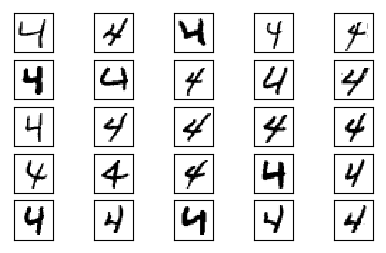

In [7]:
def plot_digit(digit):
    pixels = np.array(digit, dtype='float').reshape((28, 28))
    return plt.imshow(pixels, cmap='gray_r')


def buildFigure5x5(fig, subfiglist):
    for i, digit in enumerate(subfiglist):
        a = fig.add_subplot(5, 5, i + 1)
        plot_digit(subfiglist[i])
        a.axes.get_xaxis().set_visible(False)
        a.axes.get_yaxis().set_visible(False)

digit_4 = X[y == 4]        
buildFigure5x5(plt.figure(1), digit_4[:25])
plt.show()

### Step (a)
 Generate a scatter plot of the data in the space spanned by the first two principal components of PCA. Reconstruct $25$ points on a $5 \times 5$ grid in this space that cover the variation of the data. Render each point as an image. Arrange the images in a $5 \times 5$ grid.


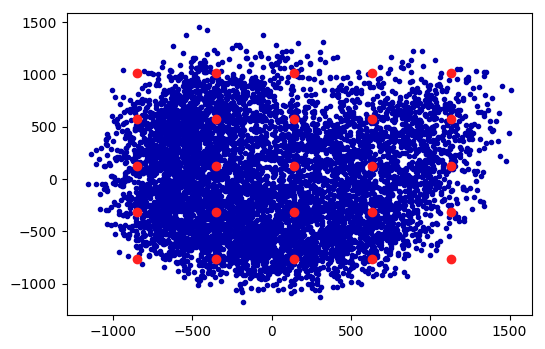

In [27]:
pts = PCA(n_components=2).fit_transform(digit_4)

plt.scatter(*pts.T, marker='.');

stdx1, stdx2 = np.std(pts.T, axis=1)
meanx1, meanx2 = np.mean(pts.T, axis=1)

minx1, maxx1 = meanx1 - 1.5 * stdx1, meanx1 + 2 * stdx1
minx2, maxx2 = meanx2 - 1.5 * stdx2, meanx2 + 2 * stdx2

gridx1 = np.arange(minx1, maxx1 + 1, (maxx1 - minx1) / 4)
gridx2 = np.arange(maxx2, minx2 - 1, -(maxx2 - minx2) / 4)

grid = np.array(list(itertools.product(gridx1, gridx2)))
plt.scatter(*grid.T, marker='o');

plt.show();

### Step (b) 
For each of the reconstructed points, find the original instance that is closest to it in the projection on the first two components (measured using Euclidean distance). Render the instances arranged in a $5 \times 5$ grid such that their position matches the rendering in (a).


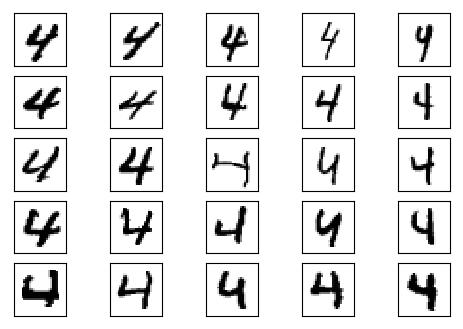

In [28]:
closest = []
for i, p in enumerate(grid):
    sq_dist = ((pts - p)**2).sum(axis=1)
    closest.append(digit_4[np.argmin(sq_dist)])

buildFigure5x5(plt.figure(1), closest)

### Step (c)
Render the mean and the first two principal components as images. What is your interpretation of the first two components, i.e., which aspect of the data do they capture? Justify your interpretation, also using your results of Steps (a) and (b).


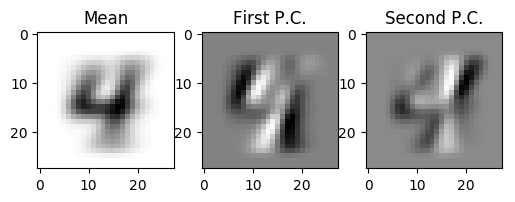

In [12]:
plt.subplot(1, 3, 1);
plt.title('Mean')
plot_digit(digit_4.mean(axis=0))

pca = PCA(n_components=2).fit(digit_4)

plt.subplot(1, 3, 2);
plt.title('First P.C.')
plot_digit(pca.components_[0]);

plt.subplot(1, 3, 3);
plt.title('Second P.C.')
plot_digit(pca.components_[1]);

plt.show();

The first principal component captures the tilt of the digit four, while the second captures the width of the top part of the digit.

## Projection onto a hyperplane (4 points)
Let $F$ be a $k$-dimensional hyperplane given by the parametric representation
$$ g(\lambda) = \mu + {\bf V} \lambda,$$
where $\mu \in \mathbb{R}^d$ and the columns of $\bf V$ are pairwise orthogonal and normal vectors $\bf v_1,\dots,v_k \in \mathbb{R}^d$.
Let $f:\mathbb{R}^d\rightarrow F$ be the projection that maps every point ${\bf p} \in \mathbb{R}^d$ to its nearest point on $F$ (where distances are measured using the Euclidean distance). We can also write $f$ as follows 
$$f({\bf p}) = g\left({\bf V}^T ({\bf p}-\mu)\right).$$

Prove that for any ${\bf p,q} \in \mathbb{R}^d$, it holds that
$$ \|f({\bf p})-f({\bf q})\| \leq \|{\bf p-q}\|. $$

(Hint: Assume first that $\mu=0$. Rewrite $f$ using a rotation followed by an orthogonal projection. What happens to the distance in each step? Generalize to arbitrary $\mu$.)


## Locality-sensitive hashing (3 points, 1+2)

$H$ is a family of $(d_1,d_2,p_1,p_2)$-locality-sensitive hash functions if it holds that
\begin{align}
\text{if}\quad d({\bf p,q})\leq d_1 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \geq p_1 \quad \\
\text{if}\quad d({\bf p,q})\geq d_2 \quad &\text{then}& \quad \Pr\left[ h({\bf p})=h({\bf q})\right] \leq p_2 \quad
\end{align}

### Case: $p_2=0$
Assume that $p_2=0$ and assume we have a total numer of $m$ hash
functions from this family available.  Which combination of AND-constructions
and OR-constructions should we use to amplify the hash family?



### Case: $p_2=\frac{1}{n}$
Now assume that $p_2=\frac{1}{n}$ and assume we have $n$ data points $\bf P$
which are stored in a hash table using a randomly chosen function $h$ from $H$.
Given a query point $\bf q$, we retrieve the points in the hash bucket with index $h(\bf q)$ to search 
for a point which has small distance to $\bf q$. 
Let $X$ be a random variable that is equal to the size of the set 

\begin{align}
\left\{{\bf p \in P}\,:\, h({\bf p})=h({\bf q}) \,\wedge\, d({\bf p,q}) \geq d_2\right\}\
\end{align}

which consists of the false positives of this query.

Derive an upper bound on the expected number of false-positives $\mathbb{E}\left[ X \right]$ using $p_2$. Explain each step of your derivation.